# 1. Generate map coordinates

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
processed_path = "../../Datasets/NYC_House_Price_Dataset/nyc_sales_03_15_cleaned.csv"
df = pd.read_csv(processed_path, encoding="utf-8-sig", low_memory=False)
gdp_path = "../../Datasets/NYC_House_Price_Dataset/ingred/NYNQGSP.csv"
gdp_df = pd.read_csv(gdp_path, encoding="utf-8-sig", low_memory=False)
mortgage_path = "../../Datasets/NYC_House_Price_Dataset/ingred/MORTGAGE.csv"
mortgage_df = pd.read_csv(mortgage_path, encoding="utf-8-sig", low_memory=False)
unemployment_path = "../../Datasets/NYC_House_Price_Dataset/ingred/NYUR.csv"
unemployment_df = pd.read_csv(unemployment_path, encoding="utf-8-sig", low_memory=False)

In [3]:
lat = df["LAT"]
lng = df["LNG"]

In [4]:
lat_min, lat_max = lat.min(), lat.max()
lng_min, lng_max = lng.min(), lng.max()

# calculate the center coordinate
center_lat = (lat_min + lat_max) / 2
center_lng = (lng_min + lng_max) / 2
print(lat_min, lat_max)
print(lng_min, lng_max)
print(center_lat, center_lng)

40.4985796 40.9126067
-74.2541463 -73.700419
40.70559315 -73.97728265


In [5]:
from math import cos, radians

EARTH_RADIUS = 6371
lat_degree_per_km = 1 / 111
lng_degree_per_km = 1 / (EARTH_RADIUS * cos(radians(center_lat)) * np.pi / 180)
print(lat_degree_per_km, lng_degree_per_km)

0.009009009009009009 0.011863295006946028


In [6]:
grid_num_lat = 200
grid_num_lng = 200
grid_length_lat = 0.2
grid_length_lng = 0.2
total_lat = grid_length_lat * grid_num_lat
total_lng = grid_length_lng * grid_num_lng
lat_span = total_lat * lat_degree_per_km
lng_span = total_lng * lng_degree_per_km
print(lat_span, lng_span)

0.36036036036036034 0.47453180027784114


In [7]:
# coordinates of four corners
north = center_lat + lat_span / 2
south = center_lat - lat_span / 2
west = center_lng - lng_span / 2
east = center_lng + lng_span / 2

corners = {
    "northwest": (north, west),
    "northeast": (north, east),
    "southwest": (south, west),
    "southeast": (south, east)
}
print(corners)

{'northwest': (40.88577333018018, -74.21454855013893), 'northeast': (40.88577333018018, -73.74001674986108), 'southwest': (40.52541296981982, -74.21454855013893), 'southeast': (40.52541296981982, -73.74001674986108)}


# 2. Calculate information gain index and transaction cnt of each month

In [8]:
from math import log2


def calculate_entropy(y):
    value_counts = y.value_counts()
    entropy = 0
    for count in value_counts:
        prob = count / len(y)
        entropy -= prob * log2(prob)
    return entropy

def calculate_information_gain(df, feature, target):
    total_entropy = calculate_entropy(df[target])
    
    feature_values = df[feature].unique()
    weighted_entropy_sum = 0
    
    for value in feature_values:
        subset = df[df[feature] == value]
        weighted_entropy_sum += (len(subset) / len(df)) * calculate_entropy(subset[target])
    
    info_gain = total_entropy - weighted_entropy_sum
    return info_gain


# target_column = 'SALE PRICE'
# exclude_columns = ['SALE PRICE', 'LAT', 'LNG', 'SALE DATE', 'MONTH']
# features = df.columns[~df.columns.isin(exclude_columns)]

# info_gains = {feature: calculate_information_gain(df, feature, target_column) for feature in features}

# info_gain_df = pd.DataFrame(list(info_gains.items()), columns=['Feature', 'Information Gain'])
# info_gain_df = info_gain_df.sort_values(by='Information Gain', ascending=False)
# print(info_gain_df)

DISTANCE, GROSS SQUARE FEET, LAND SQUARE FEET, YEAR BUILT

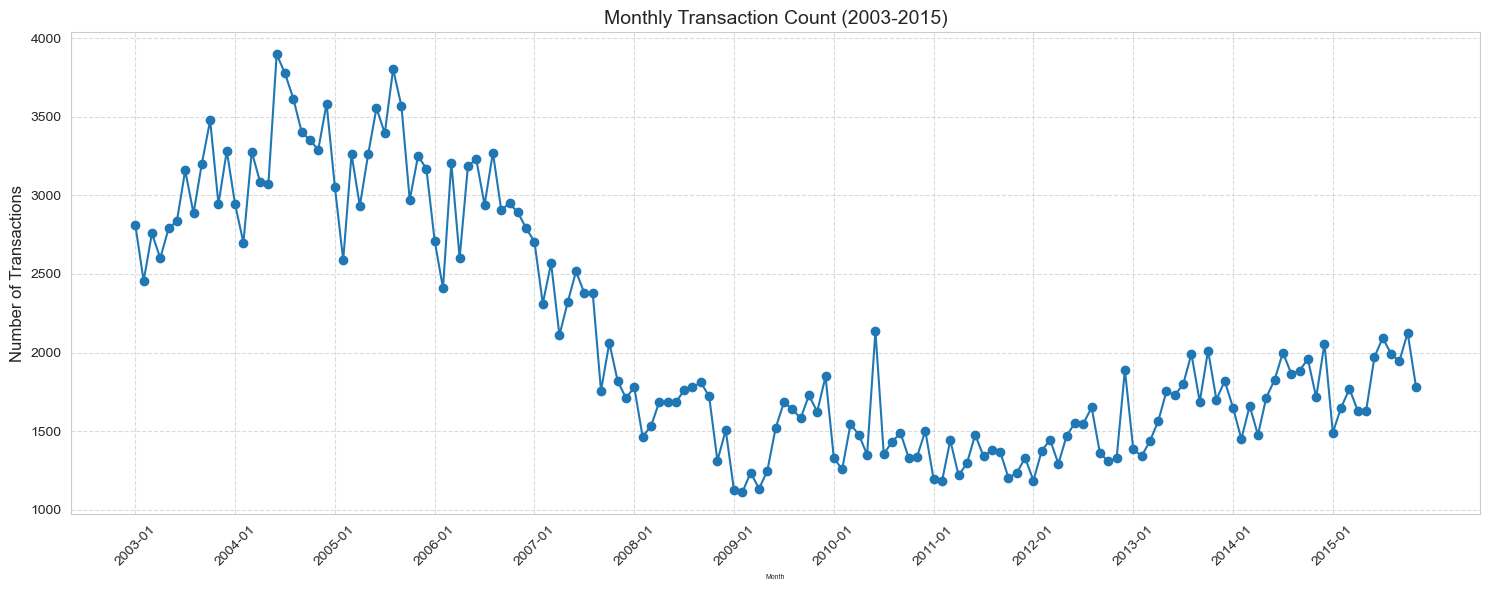

In [9]:
def plot_monthly_transactions():
    # Create lists to store data
    months = []
    transaction_counts = []
    m_cnt = 13 * 12
    
    # Collect data for each month, from 2003-01 to 2015-12
    for i in range(1, m_cnt):
        m = 2003 * 12 + i
        year = m // 12
        month = m % 12
        if month == 0:
            month = 12
            year -= 1
            
        transaction_count = len(df[df['MONTH'] == m])
        
        months.append(f"{year}-{month:02d}")
        transaction_counts.append(transaction_count)
    
    # Create the plot
    plt.figure(figsize=(15, 6))
    sns.set_style("whitegrid")
    
    # Plot line chart
    plt.plot(months, transaction_counts, marker='o')
    # Customize x-axis ticks: only show January of each year
    xticks_labels = [m for m in months if m.endswith('-01')]
    xticks_positions = [months.index(m) for m in xticks_labels]

    plt.xticks(xticks_positions, xticks_labels, rotation=45)
    # Customize the plot
    plt.title('Monthly Transaction Count (2003-2015)', fontsize=14)
    plt.xlabel('Month', fontsize=5)
    plt.ylabel('Number of Transactions', fontsize=12)
    plt.xticks(rotation=45)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt.gcf()

# Generate and display the plot
fig = plot_monthly_transactions()
plt.show()

# 3. Calculate attributes' matrix

In [10]:
def cal_house_price_mat(start: str, end: str):
    total_price = np.zeros((grid_num_lat, grid_num_lng), dtype=np.float32)
    transaction_cnt = np.zeros((grid_num_lat, grid_num_lng), dtype=np.float32)
    cnt = np.zeros((grid_num_lat, grid_num_lng), dtype=np.float32)
    
    # Find the first row with the start month
    start_idx = df[df["MONTH"] >= start].index[0]

    for _, row in df.iloc[start_idx:].iterrows():
        cur_lat = row["LAT"]
        cur_lng = row["LNG"]
        month = row["MONTH"]
        if month > end:
            break
        if start <= month <= end and south <= cur_lat <= north and west <= cur_lng <= east:
            ri = int(abs(cur_lat - north) // (lat_degree_per_km * grid_length_lat))
            ci = int(abs(cur_lng - west) // (lng_degree_per_km * grid_length_lng))
            if 0 <= ri < grid_num_lat and 0 <= ci < grid_num_lng:
                total_price[ri, ci] += np.float32(row["SALE PRICE"])
                transaction_cnt[ri, ci] += np.float32(1)
                cnt[ri, ci] += np.float32(1)

    devider = np.where(cnt == 0, np.float32(1e-6), cnt).astype(np.float32)
    
    return (total_price / devider).astype(np.float32), transaction_cnt.astype(np.float32)


data for ingredients

In [11]:
# 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
avg_incoming = [37420, 39093, 40645, 43760, 47020, 47909, 46936, 48579, 50775, 52628, 52875, 54495, 56603]
permanent_residents = [19175.939, 19171.567, 19132.610, 19104.631, 19132.335, 19212.436, 19307.066, 19399.956, 19499.921, 19574.362, 19626.488, 19653.431, 19657.321]
economics = [avg_incoming, permanent_residents]

In [12]:
# DISTANCE, GROSS SQUARE FEET, LAND SQUARE FEET, YEAR BUILT
def cal_ingredients_mat(start: str, end: str):
    distance = np.zeros((grid_num_lat, grid_num_lng), dtype=np.float32)
    gross = np.zeros((grid_num_lat, grid_num_lng), dtype=np.float32)
    land = np.zeros((grid_num_lat, grid_num_lng), dtype=np.float32)
    year = np.zeros((grid_num_lat, grid_num_lng), dtype=np.float32)
    cnt = np.zeros((grid_num_lat, grid_num_lng), dtype=np.float32)

    # Find the first row with the start month
    start_idx = df[df["MONTH"] >= start].index[0]

    for _, row in df.iloc[start_idx:].iterrows():
        cur_lat = row["LAT"]
        cur_lng = row["LNG"]
        month = row["MONTH"]
        if month > end:
            break
        if start <= month <= end and south <= cur_lat <= north and west <= cur_lng <= east:
            ri = int(abs(cur_lat - north) // (lat_degree_per_km * grid_length_lat))
            ci = int(abs(cur_lng - west) // (lng_degree_per_km * grid_length_lng))
            if 0 <= ri < grid_num_lat and 0 <= ci < grid_num_lng:
                distance[ri, ci] += np.float32(row["DISTANCE"])
                gross[ri, ci] += np.float32(row["GROSS SQUARE FEET"])
                land[ri, ci] += np.float32(row["LAND SQUARE FEET"])
                year[ri, ci] += np.float32(row["YEAR BUILT"])
                cnt[ri, ci] += np.float32(1)

    devider = np.where(cnt == 0, np.float32(1e-6), cnt).astype(np.float32)

    return (
        (distance / devider).astype(np.float32),
        (gross / devider).astype(np.float32),
        (land / devider).astype(np.float32),
        (year / devider).astype(np.float32),
    )


In [13]:
test_price, test_transaction_cnt = cal_house_price_mat(2003 * 12 + 1, 2015 * 12 + 12)
test_distance, test_gross, test_land, test_year = cal_ingredients_mat(2003 * 12 + 1, 2015 * 12 + 12)

In [14]:
def plot_feature_maps(data_dict: dict, figsize: tuple = (20, 40)):
    n_features = len(data_dict)
    fig, axes = plt.subplots(n_features, 2, figsize=figsize)
    
    for i, (title, data) in enumerate(data_dict.items()):
        height, width = data.shape

        im1 = axes[i, 0].imshow(data, cmap='gray', interpolation='none')
        axes[i, 0].set_title(f"{title} (Grayscale)", fontsize=20)
        
        axes[i, 0].set_xticklabels([])
        axes[i, 0].set_yticklabels([])
        fig.colorbar(im1, ax=axes[i, 0], fraction=0.046, pad=0.04)

        im2 = axes[i, 1].imshow(data, cmap='turbo', interpolation='none')
        axes[i, 1].set_title(f"{title} (Colored Intensity)", fontsize=20)
        
        axes[i, 1].set_xticklabels([])
        axes[i, 1].set_yticklabels([])
        fig.colorbar(im2, ax=axes[i, 1], fraction=0.046, pad=0.04)
    
    plt.subplots_adjust(hspace=0.3, wspace=0.05)
    plt.show()

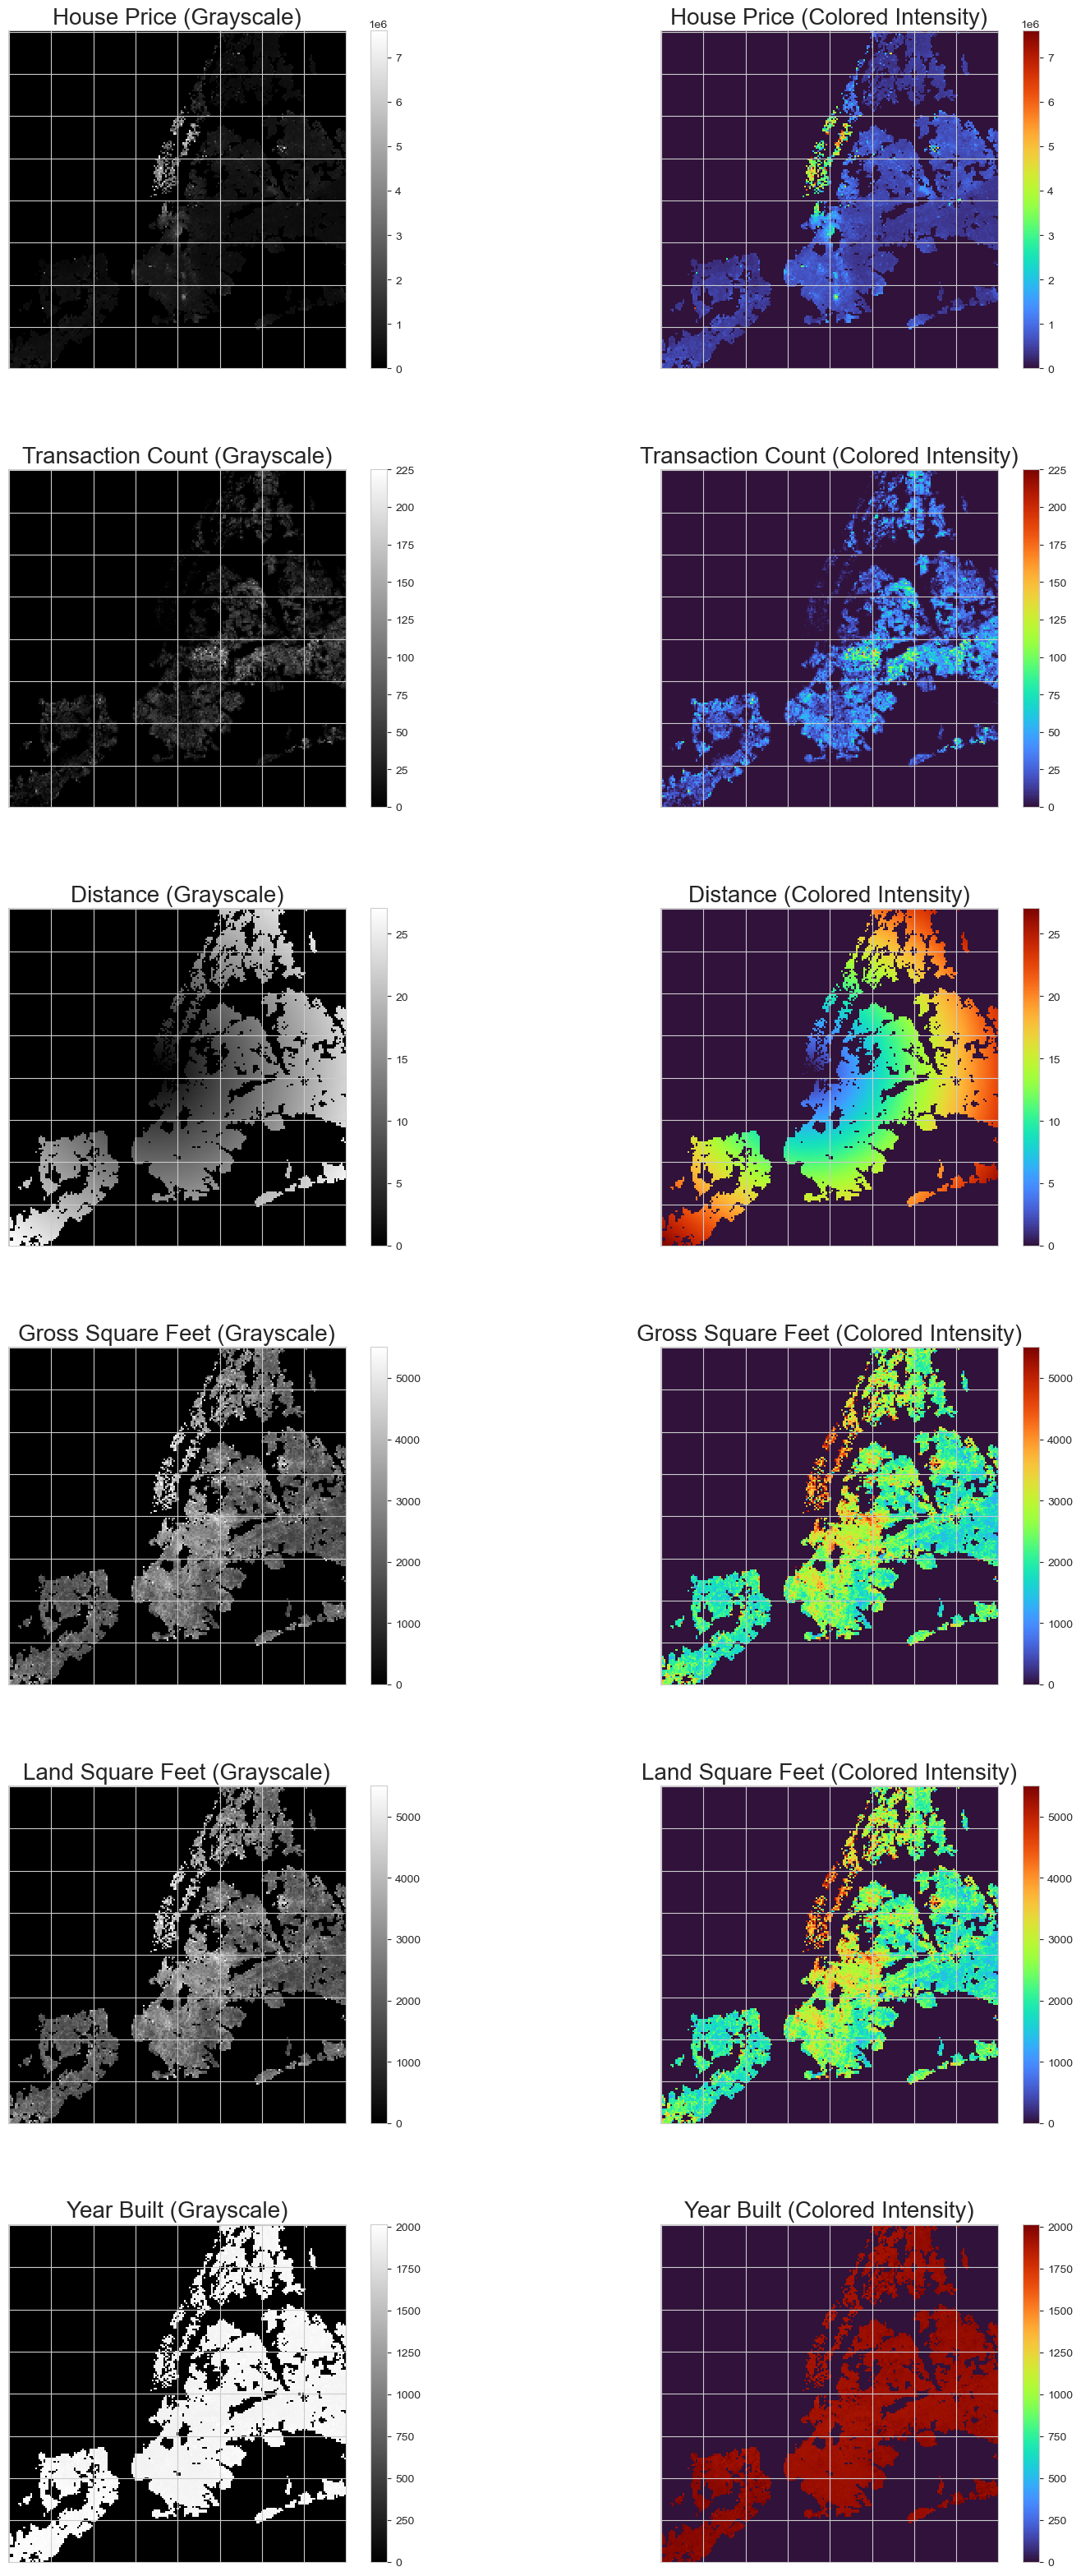

In [15]:
feature_maps = {
    "House Price": test_price,
    "Transaction Count": test_transaction_cnt,
    "Distance": test_distance,
    "Gross Square Feet": test_gross,
    "Land Square Feet": test_gross,
    "Year Built": test_year,
}
plot_feature_maps(feature_maps)

## 3.1 Generate each month price for further processing

In [16]:
start_y = 2003 * 12 + 1
end_y = 2015 * 12 + 12
price_ls = []
for y in range(start_y, end_y + 1):
    price_ls.append(cal_house_price_mat(y, y)[0])
print(len(price_ls))

156


# 4. Generate mask and corresponding tensor

In [17]:
mask = (test_price != 0).astype(np.float32)

In [ ]:
def kalman_interpolation(current_matrix, prev_list, process_noise=1e-5, measurement_noise=1e-1):
    estimated_matrix = current_matrix.copy()
    rows, cols = current_matrix.shape

    for i in range(rows):
        for j in range(cols):
            if current_matrix[i, j] == 0:
                x_est = prev_list[0][i, j]
                P = measurement_noise
                for month_data in prev_list[1:]:
                    x_pred = x_est
                    P_pred = P + process_noise
                    
                    z = month_data[i, j]
                    K = P_pred / (P_pred + measurement_noise)
                    x_est = x_pred + K * (z - x_pred)
                    P = (1 - K) * P_pred
                x_pred = x_est
                estimated_matrix[i, j] = x_pred

    return estimated_matrix

In [19]:
def year(start: str, end: str):
    ls = []
    for i in range(end - start + 1):
        cur_month = start + i
        cur_ls = []
        # long term
        cur_ls.append([cur_month - 24, cur_month - 12, cur_month])
        ls.append(cur_ls)
        # short term
        cur_ls.append([cur_month - 12 + j for j in range(12)])
        # ingredients
        cur_ls.append([cur_month - 12, cur_month])
        # future expectation
        cur_ls.append([cur_month - 1, cur_month])
        # traning label
        cur_ls.append([cur_month + 1]) 
    return ls

In [20]:
# short term price set as 12 months, shape: 12x(grid_num)x(grid_num)
# long term price set as 2 years, shape: 2x(grid_num)x(grid_num)
# ingredients set as 1 year, shape: (m+k)x(grid_num)x(grid_num)
# future expectation set as 2 months, shape: 2x(grid_num)x(grid_num)
# label set as 1 month, shape: 1x(grid_num)x(grid_num)

def generate_npz_JGC_MMN(path: str, t):
    long_term_tensor = []
    short_term_tensor = []
    ingredients_tensor = []
    future_tensor = []
    label_tensor = []
    for cur_t in t:
        # long term
        long_price = []
        long_cnt = []
        for cur_y in range(len(cur_t[0]) - 1):
            m1 = cur_t[0][cur_y]
            m2 = cur_t[0][cur_y + 1]
            l_price, l_cnt = cal_house_price_mat(m1, m2)
            l_price[mask == 0] = -np.inf
            if np.any(l_price == 0):
                prev_mat = price_ls[m2 - 2003 * 12 - 13: m2 - 2003 * 12 - 1]
                l_price = kalman_interpolation(l_price, prev_mat)
            l_price[np.isneginf(l_price)] = 0
            long_price.append(l_price)
            long_cnt.append(l_cnt)
        long_term_tensor.append(np.stack(long_price + long_cnt, axis=0))
        
        # short term
        short_price = []
        short_cnt = []
        for cur_m in cur_t[1]:
            s_price, s_cnt = cal_house_price_mat(cur_m, cur_m)
            s_price[mask == 0] = -np.inf
            if np.any(s_price == 0):
                prev_mat = price_ls[cur_m - 2003 * 12 - 13: cur_m - 2003 * 12 - 1]
                s_price = kalman_interpolation(s_price, prev_mat)
            s_price[np.isneginf(s_price)] = 0
            short_price.append(s_price)
            short_cnt.append(s_cnt)
        short_term_tensor.append(np.stack(short_price + short_cnt, axis=0))
        
        # ingredients
        ingre_arr = []
        for cur_m in range(len(cur_t[2]) - 1):
            m1 = cur_t[2][cur_m]
            m2 = cur_t[2][cur_m + 1]
            cur_y = m1 // 12 - 2003
            for eco in economics:
                eco_mat = np.full((grid_num_lat, grid_num_lng), eco[cur_y], dtype=np.float32)
                eco_mat[mask == 0] = 0
                ingre_arr.append(eco_mat)
            #  add GDP growth rate
            quarter = (m2 // 12) * 4 + (m2 % 12) // 3 + 1
            gdp_1 = np.mean(gdp_df[gdp_df["quarter"] == quarter - 1]["NYNQGSP"])
            gdp_2 = np.mean(gdp_df[gdp_df["quarter"] == quarter]["NYNQGSP"])
            gdp_rate = (gdp_2 - gdp_1) / gdp_1
            gdp_mat = np.full((grid_num_lat, grid_num_lng), gdp_rate, dtype=np.float32)
            gdp_mat[mask == 0] = 0
            ingre_arr.append(gdp_mat)
            # add mortgage rate
            mortgage_rate = np.mean(mortgage_df[(mortgage_df["month"] >= m1) & 
                                    (mortgage_df["month"] <= m2)]["MORTGAGE30US"])
            mortgage_mat = np.full((grid_num_lat, grid_num_lng), mortgage_rate, dtype=np.float32)
            mortgage_mat[mask == 0] = 0
            ingre_arr.append(mortgage_mat)
            # add unemployment rate
            unemployment_rate = np.mean(unemployment_df[(unemployment_df["month"] >= m1) &
                                        (unemployment_df["month"] <= m2)]["NYUR"])
            unemployment_mat = np.full((grid_num_lat, grid_num_lng), unemployment_rate, dtype=np.float32)
            unemployment_mat[mask == 0] = 0
            ingre_arr.append(unemployment_mat)
            # add distance, gross, land, year
            ingre_arr.extend(cal_ingredients_mat(m1, m2))
        ingredients_tensor.append(np.stack(ingre_arr, axis=0))
        
        # future expectation
        future_arr = []
        for cur_m in cur_t[3]:
            future_price = cal_house_price_mat(cur_m, cur_m)[0]
            future_price[mask == 0] = -np.inf
            if np.any(future_price == 0):
                prev_mat = price_ls[cur_m - 2003 * 12 - 13: cur_m - 2003 * 12 - 1]
                future_price = kalman_interpolation(future_price, prev_mat)
            future_price[np.isneginf(future_price)] = 0
            future_arr.append(future_price)
        future_tensor.append(np.stack(future_arr, axis=0))
        
        # label
        year = cur_t[4][0] // 12
        month = cur_t[4][0] % 12
        if month == 0:
            print("label: ", year - 1, 12)
        else:
            print("label: ", year, month)
        label_price = cal_house_price_mat(cur_t[4][0], cur_t[4][0])[0]
        label_price[mask == 0] = -np.inf
        if np.any(label_price == 0):
            prev_mat = price_ls[cur_t[4][0] - 2003 * 12 - 13: cur_t[4][0] - 2003 * 12 - 1]
            label_price = kalman_interpolation(label_price, prev_mat)
        label_price[np.isneginf(label_price)] = 0
        label_tensor.append(np.stack([label_price], axis=0))
    long_term_tensor = np.stack(long_term_tensor, axis=0)
    short_term_tensor = np.stack(short_term_tensor, axis=0)
    ingredients_tensor = np.stack(ingredients_tensor, axis=0)
    future_tensor = np.stack(future_tensor, axis=0)
    label_tensor = np.stack(label_tensor, axis=0)
    print("--------------------------------------------------")
    print("long term tensor shape: ", long_term_tensor.shape)
    print("short term tensor shape: ", short_term_tensor.shape)
    print("ingredients tensor shape: ", ingredients_tensor.shape)
    print("future tensor shape: ", future_tensor.shape)
    print("label tensor shape: ", label_tensor.shape)
    print("--------------------------------------------------")
    np.save(path + "long_term.npy", long_term_tensor)
    np.save(path + "short_term.npy", short_term_tensor)
    np.save(path + "ingredients.npy", ingredients_tensor)
    np.save(path + "future.npy", future_tensor)
    np.save(path + "label.npy", label_tensor)

In [21]:
train_start = 2005 * 12 + 4
train_end = 2014 * 12 + 11
test_start = 2014 * 12 + 12
test_end = 2015 * 12 + 11

In [22]:
t1 = year(train_start, train_end)
generate_npz_JGC_MMN("../../Datasets/NYC_House_Price_Dataset/ST/train/", t1)

label:  2005 5
label:  2005 6
label:  2005 7
label:  2005 8
label:  2005 9
label:  2005 10
label:  2005 11
label:  2005 12
label:  2006 1
label:  2006 2
label:  2006 3
label:  2006 4
label:  2006 5
label:  2006 6
label:  2006 7
label:  2006 8
label:  2006 9
label:  2006 10
label:  2006 11
label:  2006 12
label:  2007 1
label:  2007 2
label:  2007 3
label:  2007 4
label:  2007 5
label:  2007 6
label:  2007 7
label:  2007 8
label:  2007 9
label:  2007 10
label:  2007 11
label:  2007 12
label:  2008 1
label:  2008 2
label:  2008 3
label:  2008 4
label:  2008 5
label:  2008 6
label:  2008 7
label:  2008 8
label:  2008 9
label:  2008 10
label:  2008 11
label:  2008 12
label:  2009 1
label:  2009 2
label:  2009 3
label:  2009 4
label:  2009 5
label:  2009 6
label:  2009 7
label:  2009 8
label:  2009 9
label:  2009 10
label:  2009 11
label:  2009 12
label:  2010 1
label:  2010 2
label:  2010 3
label:  2010 4
label:  2010 5
label:  2010 6
label:  2010 7
label:  2010 8
label:  2010 9
label:  20

In [23]:
t2 = year(test_start, test_end)
generate_npz_JGC_MMN("../../Datasets/NYC_House_Price_Dataset/ST/test/", t2)

label:  2015 1
label:  2015 2
label:  2015 3
label:  2015 4
label:  2015 5
label:  2015 6
label:  2015 7
label:  2015 8
label:  2015 9
label:  2015 10
label:  2015 11
label:  2015 12
--------------------------------------------------
long term tensor shape:  (12, 4, 200, 200)
short term tensor shape:  (12, 24, 200, 200)
ingredients tensor shape:  (12, 9, 200, 200)
future tensor shape:  (12, 2, 200, 200)
label tensor shape:  (12, 1, 200, 200)
--------------------------------------------------


In [24]:
np.save("../../Datasets/NYC_House_Price_Dataset/ST/train/" + "mask.npy", mask)
np.save("../../Datasets/NYC_House_Price_Dataset/ST/test/" + "mask.npy", mask)

# 5. Generate corresponding RGB img for checking

In [25]:
import os


def save_colored_images_from_npz(npz_file_path, output_folder, colormap='turbo'):

    tensor = np.load(npz_file_path)

    tensor = tensor[:, :tensor.shape[1] // 2, :, :]
    
    os.makedirs(output_folder, exist_ok=True)
    
    cmap = plt.get_cmap(colormap)
    
    cnt = 0

    start = train_start

    for i in range(tensor.shape[0]):
        cur_start = start + i - 12
        cur_start_y = cur_start // 12
        cur_start_m = cur_start % 12
        if cur_start_m == 0:
            cur_start_m = 12
            cur_start_y -= 1
        for j in range(tensor.shape[1]):
            gray_img = tensor[i, j, :, :]
            gray_img[mask == 0] = -np.inf
            if np.any(gray_img == 0):
                cnt += 1
            gray_img[np.isneginf(gray_img)] = 0
            norm_img = (gray_img - gray_img.min()) / (gray_img.max() - gray_img.min() + 1e-8)
            rgba_img = cmap(norm_img)
            rgb_img = (rgba_img[:, :, :3] * 255).astype(np.uint8)

            local_start = cur_start + j
            local_start_y = local_start // 12
            local_start_m = local_start % 12
            if local_start_m == 0:
                local_start_m = 12
                local_start_y -= 1

            file_name = os.path.join(output_folder, f"{cur_start_y}_{cur_start_m}-{local_start_y}_{local_start_m}.png")
            plt.imsave(file_name, rgb_img)
            print(f"save img: {file_name}")

    print(f"total: {cnt}")


In [26]:
npz_file_path = "../../Datasets/NYC_House_Price_Dataset/ST/train/short_term.npy" 
output_folder = "../../Datasets/NYC_House_Price_Dataset/preview/"
save_colored_images_from_npz(npz_file_path, output_folder)

save img: ../../Datasets/NYC_House_Price_Dataset/preview/2004_4-2004_4.png
save img: ../../Datasets/NYC_House_Price_Dataset/preview/2004_4-2004_5.png
save img: ../../Datasets/NYC_House_Price_Dataset/preview/2004_4-2004_6.png
save img: ../../Datasets/NYC_House_Price_Dataset/preview/2004_4-2004_7.png
save img: ../../Datasets/NYC_House_Price_Dataset/preview/2004_4-2004_8.png
save img: ../../Datasets/NYC_House_Price_Dataset/preview/2004_4-2004_9.png
save img: ../../Datasets/NYC_House_Price_Dataset/preview/2004_4-2004_10.png
save img: ../../Datasets/NYC_House_Price_Dataset/preview/2004_4-2004_11.png
save img: ../../Datasets/NYC_House_Price_Dataset/preview/2004_4-2004_12.png
save img: ../../Datasets/NYC_House_Price_Dataset/preview/2004_4-2005_1.png
save img: ../../Datasets/NYC_House_Price_Dataset/preview/2004_4-2005_2.png
save img: ../../Datasets/NYC_House_Price_Dataset/preview/2004_4-2005_3.png
save img: ../../Datasets/NYC_House_Price_Dataset/preview/2004_5-2004_5.png
save img: ../../Datase

In [27]:
mask.shape

(200, 200)

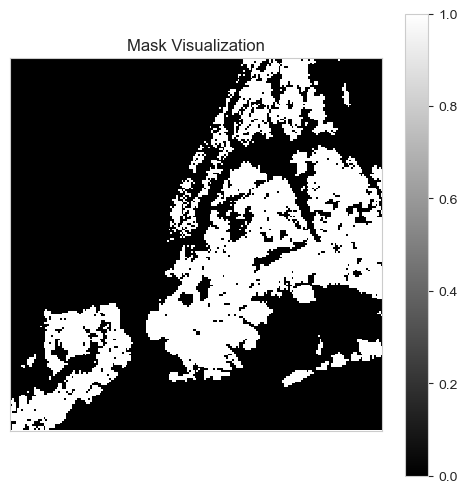

In [28]:
plt.figure(figsize=(6, 6))

plt.imshow(mask, cmap='gray', interpolation='none')

plt.colorbar()

plt.title("Mask Visualization")

plt.xticks([])
plt.yticks([])

plt.show()

In [29]:
np.sum(mask == 1)

11550

In [30]:
np.sum(mask == 0)

28450

In [31]:
test_price_1 = test_price[mask == 1]
len(test_price_1)

11550